# Wine Quality EDA — Alcohol Regimes and Chemical Drivers

This notebook explores the Wine Quality dataset to:
- identify key chemical drivers associated with `quality`
- test whether alcohol defines structurally distinct regimes (<10%, 10–12%, >12%)
- compare correlations and profiles across regimes to support downstream modeling and risk simulation.


In [1]:
import pandas as pd
import numpy as np
import yaml
from pathlib import Path

# Load project configuration
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_PATH = Path("..") / config["paths"]["raw_data"]
WINE_QUALITY_FILE = config["files"]["wine_quality"]



In [2]:
wine_quality = pd.read_csv(RAW_PATH / WINE_QUALITY_FILE)

wine_quality.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [3]:
wine_quality.shape


(1143, 13)

In [4]:
wine_quality.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [5]:
wine_quality.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


In [6]:
wine_quality.isna().sum()


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

In [7]:
wine_quality.duplicated().sum()


np.int64(0)

In [8]:
corr = wine_quality.corr(numeric_only=True)
corr["quality"].sort_values(ascending=False)


quality                 1.000000
alcohol                 0.484866
sulphates               0.257710
citric acid             0.240821
fixed acidity           0.121970
Id                      0.069708
residual sugar          0.022002
pH                     -0.052453
free sulfur dioxide    -0.063260
chlorides              -0.124085
density                -0.175208
total sulfur dioxide   -0.183339
volatile acidity       -0.407394
Name: quality, dtype: float64

In [9]:
# Segmentation variables (defined once for reproducibility)
wine_quality["low_alcohol"] = wine_quality["alcohol"] < 10
wine_quality["alcohol_segment"] = np.where(wine_quality["low_alcohol"], "< 10%", ">= 10%")

wine_quality["alcohol_segment_3"] = pd.cut(
    wine_quality["alcohol"],
    bins=[0, 10, 12, float("inf")],
    labels=["<10%", "10–12%", ">12%"],
    right=False
)


## Alcohol threshold analysis (alcohol < 10%)

This section explores whether wines with alcohol content below 10% exhibit systematically different chemical profiles and quality outcomes.

The objective is to understand whether low-alcohol wines represent a structurally distinct segment rather than noise or outliers.


In [10]:

# Ensure low_alcohol exists
if "low_alcohol" not in wine_quality.columns:
    wine_quality["low_alcohol"] = wine_quality["alcohol"] < 10

wine_quality["alcohol_segment"] = np.where(wine_quality["low_alcohol"], "< 10%", ">= 10%")


In [11]:
wine_quality["low_alcohol"].value_counts(normalize=True)


low_alcohol
False    0.575678
True     0.424322
Name: proportion, dtype: float64

In [12]:
wine_quality.groupby("low_alcohol")["quality"].agg(
    ["count", "mean", "median", "std"]
)


,count,mean,median,std
low_alcohol,,,,
False,658,5.936170,6.0,0.821439
True,485,5.278351,5.0,0.605455


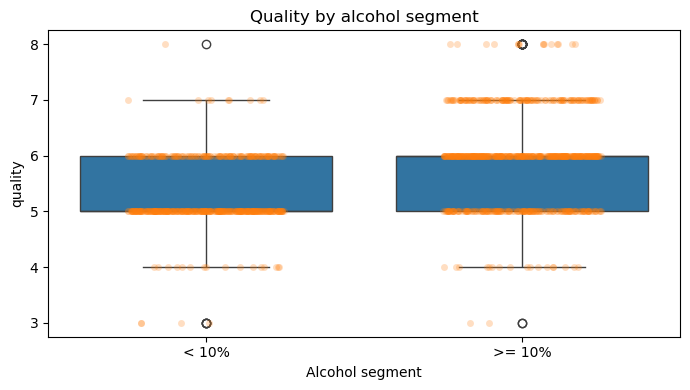

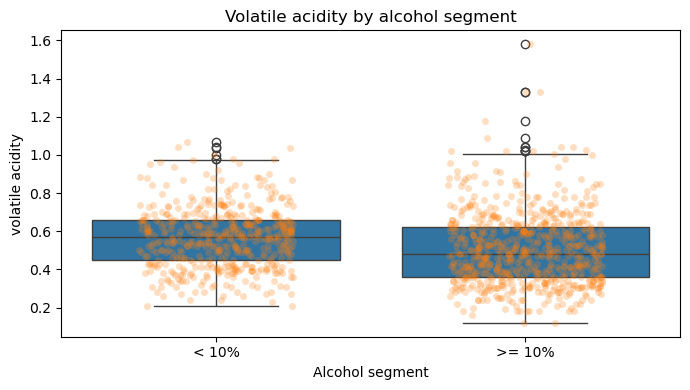

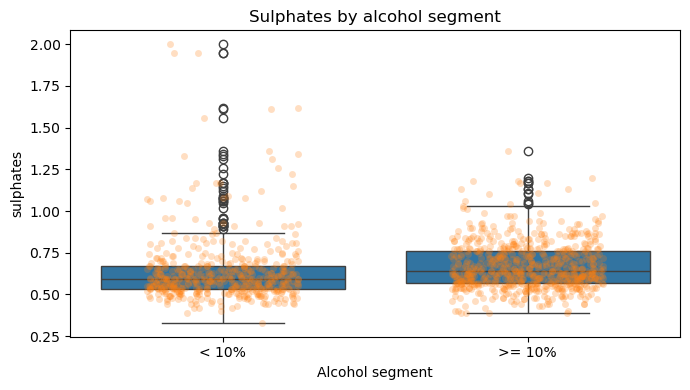

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def box_with_points(df, y_col, title):
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x="alcohol_segment", y=y_col)
    sns.stripplot(data=df, x="alcohol_segment", y=y_col, alpha=0.25, jitter=0.25)
    plt.title(title)
    plt.xlabel("Alcohol segment")
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

box_with_points(wine_quality, "quality", "Quality by alcohol segment")
box_with_points(wine_quality, "volatile acidity", "Volatile acidity by alcohol segment")
box_with_points(wine_quality, "sulphates", "Sulphates by alcohol segment")



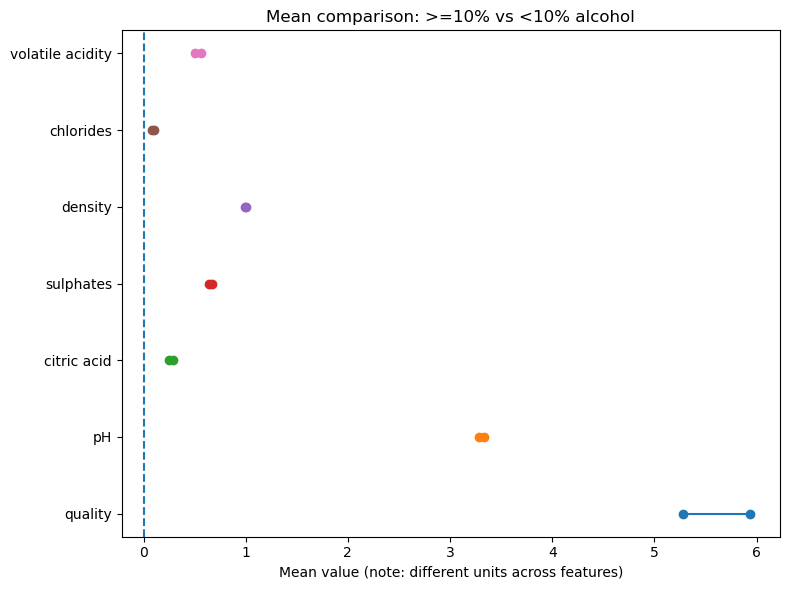

,< 10%,>= 10%,diff_<10_minus_>=10
quality,5.278351,5.936170,-0.657820
pH,3.280969,3.333161,-0.052192
citric acid,0.245320,0.285350,-0.040030
sulphates,0.641010,0.670015,-0.029005
density,0.997437,0.996210,0.001227
chlorides,0.098012,0.078766,0.019246
volatile acidity,0.565454,0.506193,0.059261


In [14]:
features = ["volatile acidity", "sulphates", "chlorides", "pH", "density", "citric acid", "quality"]

means = wine_quality.groupby("alcohol_segment")[features].mean().T
means.columns = ["< 10%", ">= 10%"]
means["diff_<10_minus_>=10"] = means["< 10%"] - means[">= 10%"]

means_sorted = means.sort_values("diff_<10_minus_>=10")

plt.figure(figsize=(8,6))
for i, feat in enumerate(means_sorted.index):
    plt.plot([means_sorted.loc[feat, ">= 10%"], means_sorted.loc[feat, "< 10%"]], [i, i], marker="o")
plt.yticks(range(len(means_sorted.index)), means_sorted.index)
plt.axvline(0, linestyle="--")
plt.title("Mean comparison: >=10% vs <10% alcohol")
plt.xlabel("Mean value (note: different units across features)")
plt.tight_layout()
plt.show()

means_sorted


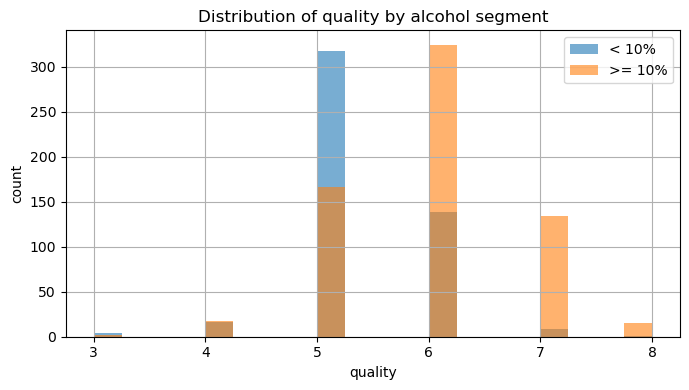

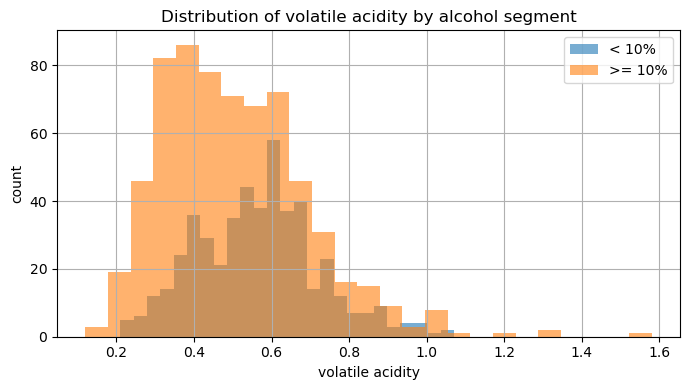

In [15]:
def hist_by_segment(df, col, bins=30):
    plt.figure(figsize=(7,4))
    df[df["alcohol_segment"] == "< 10%"][col].hist(bins=bins, alpha=0.6)
    df[df["alcohol_segment"] == ">= 10%"][col].hist(bins=bins, alpha=0.6)
    plt.title(f"Distribution of {col} by alcohol segment")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.legend(["< 10%", ">= 10%"])
    plt.tight_layout()
    plt.show()

hist_by_segment(wine_quality, "quality", bins=20)
hist_by_segment(wine_quality, "volatile acidity", bins=25)



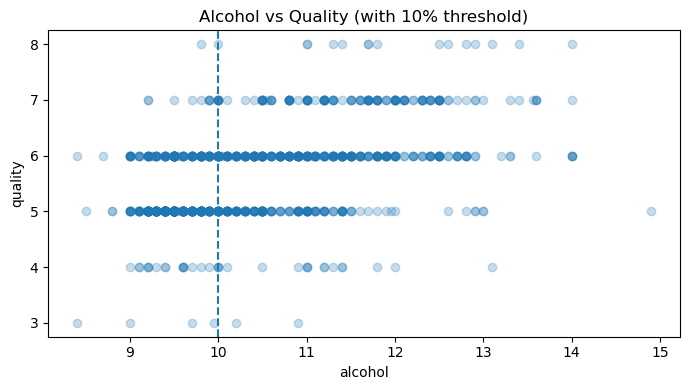

In [16]:
plt.figure(figsize=(7,4))
plt.scatter(wine_quality["alcohol"], wine_quality["quality"], alpha=0.25)
plt.axvline(10, linestyle="--")
plt.title("Alcohol vs Quality (with 10% threshold)")
plt.xlabel("alcohol")
plt.ylabel("quality")
plt.tight_layout()
plt.show()


The scatter plot shows a clear structural change around the 10% alcohol threshold. Wines below this level exhibit a narrow quality range, while higher-quality wines only appear above 10%. This supports using 10% alcohol as a meaningful analytical cutoff rather than an arbitrary split.



## Alcohol segmentation analysis (<10%, 10–12%, >12%)

This section extends the alcohol threshold analysis by splitting wines into three alcohol ranges
to assess how chemical composition and quality evolve across segments.


In [17]:
import numpy as np

wine_quality["alcohol_segment_3"] = pd.cut(
    wine_quality["alcohol"],
    bins=[0, 10, 12, np.inf],
    labels=["<10%", "10–12%", ">12%"],
    right=False
)

wine_quality["alcohol_segment_3"].value_counts()


alcohol_segment_3
10–12%    536
<10%      485
>12%      122
Name: count, dtype: int64

In [18]:
wine_quality.groupby("alcohol_segment_3")["quality"].agg(
    ["count", "mean", "median", "std"]
)


C:\Users\Marta\AppData\Local\Temp\ipykernel_3724\1265984070.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wine_quality.groupby("alcohol_segment_3")["quality"].agg(


,count,mean,median,std
alcohol_segment_3,,,,
<10%,485,5.278351,5.0,0.605455
10–12%,536,5.824627,6.0,0.791916
>12%,122,6.426230,6.0,0.770511


In [19]:
features = [
    "quality",
    "volatile acidity",
    "sulphates",
    "chlorides",
    "density",
    "pH",
    "citric acid"
]

segment_means = wine_quality.groupby("alcohol_segment_3")[features].mean()
segment_means


C:\Users\Marta\AppData\Local\Temp\ipykernel_3724\3081071344.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_means = wine_quality.groupby("alcohol_segment_3")[features].mean()


,quality,volatile acidity,sulphates,chlorides,density,pH,citric acid
alcohol_segment_3,,,,,,,
<10%,5.278351,0.565454,0.641010,0.098012,0.997437,3.280969,0.245320
10–12%,5.824627,0.519496,0.665746,0.080735,0.996559,3.324608,0.276642
>12%,6.426230,0.447746,0.688770,0.070115,0.994674,3.370738,0.323607


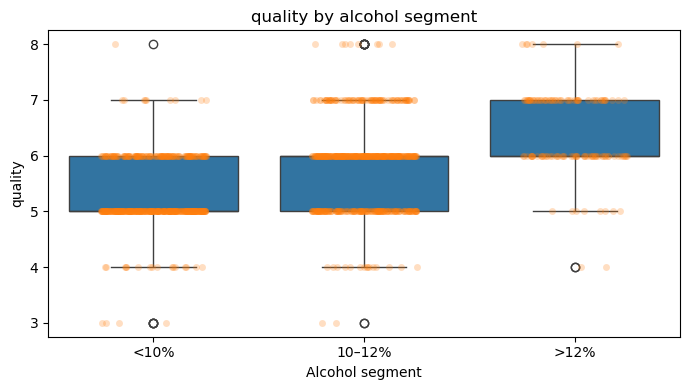

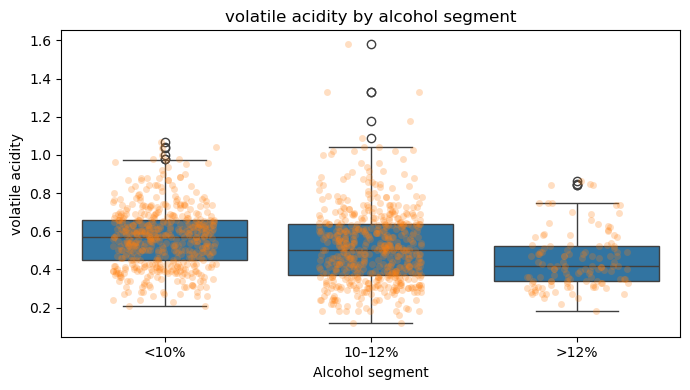

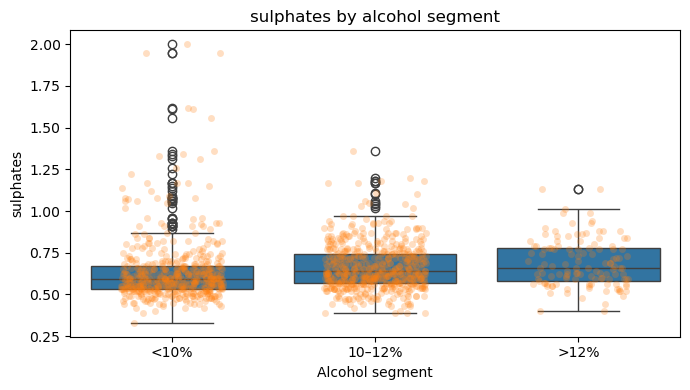

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def box_by_segment(df, y_col):
    plt.figure(figsize=(7,4))
    sns.boxplot(
        data=df,
        x="alcohol_segment_3",
        y=y_col,
        order=["<10%", "10–12%", ">12%"]
    )
    sns.stripplot(
        data=df,
        x="alcohol_segment_3",
        y=y_col,
        order=["<10%", "10–12%", ">12%"],
        alpha=0.25,
        jitter=0.25
    )
    plt.title(f"{y_col} by alcohol segment")
    plt.xlabel("Alcohol segment")
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

for col in ["quality", "volatile acidity", "sulphates"]:
    box_by_segment(wine_quality, col)


In [21]:
# Differences relative to the middle segment (10–12%)
baseline = segment_means.loc["10–12%"]

diff_table = segment_means.subtract(baseline)
diff_table


,quality,volatile acidity,sulphates,chlorides,density,pH,citric acid
alcohol_segment_3,,,,,,,
<10%,-0.546276,0.045957,-0.024736,0.017277,0.000877,-0.043639,-0.031322
10–12%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
>12%,0.601603,-0.071750,0.023024,-0.010620,-0.001885,0.046129,0.046965


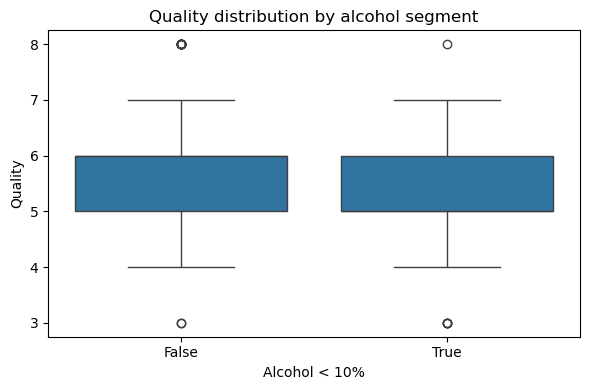

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(
    x="low_alcohol",
    y="quality",
    data=wine_quality
)
plt.xlabel("Alcohol < 10%")
plt.ylabel("Quality")
plt.title("Quality distribution by alcohol segment")
plt.tight_layout()
plt.show()


In [23]:
key_features = [
    "volatile acidity",
    "sulphates",
    "chlorides",
    "pH",
    "density",
    "citric acid"
]

wine_quality.groupby("low_alcohol")[key_features].mean()


,volatile acidity,sulphates,chlorides,pH,density,citric acid
low_alcohol,,,,,,
False,0.506193,0.670015,0.078766,3.333161,0.996210,0.28535
True,0.565454,0.641010,0.098012,3.280969,0.997437,0.24532


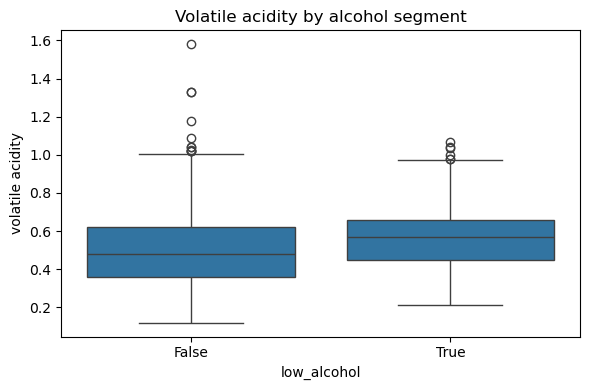

In [24]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="low_alcohol",
    y="volatile acidity",
    data=wine_quality
)
plt.title("Volatile acidity by alcohol segment")
plt.tight_layout()
plt.show()


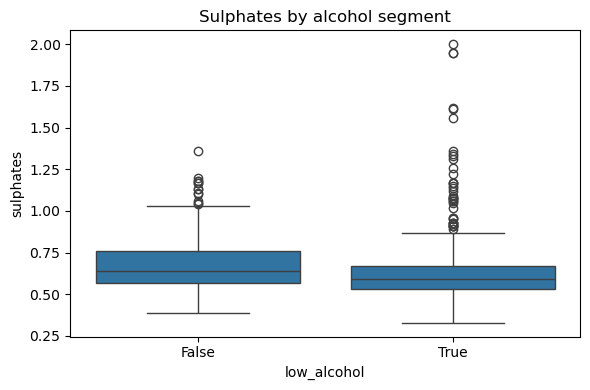

In [25]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="low_alcohol",
    y="sulphates",
    data=wine_quality
)
plt.title("Sulphates by alcohol segment")
plt.tight_layout()
plt.show()


In [26]:
# Select only numeric columns for correlation
numeric_cols = wine_quality.select_dtypes(include="number").columns

low_corr = (
    wine_quality[wine_quality["low_alcohol"]][numeric_cols]
    .corr()["quality"]
)

high_corr = (
    wine_quality[~wine_quality["low_alcohol"]][numeric_cols]
    .corr()["quality"]
)

corr_comparison = pd.DataFrame({
    "low_alcohol": low_corr,
    "high_alcohol": high_corr
}).sort_values(by="low_alcohol")

corr_comparison


,low_alcohol,high_alcohol
volatile acidity,-0.307380,-0.411154
total sulfur dioxide,-0.162889,-0.050377
free sulfur dioxide,-0.150054,0.016832
pH,-0.043492,-0.180852
chlorides,-0.020898,-0.109043
Id,-0.019677,-0.035218
residual sugar,-0.017947,0.024928
density,0.050742,-0.095178
citric acid,0.092702,0.283804
alcohol,0.130303,0.344584


## Alcohol range segmentation and correlation analysis

This section analyzes how the relationship between key chemical parameters and wine quality
changes across alcohol ranges (<10%, 10–12%, >12%).

The objective is to identify whether alcohol level modulates the impact of other variables on quality.


In [27]:
if "Id" in wine_quality.columns:
    wine_quality = wine_quality.drop(columns=["Id"])


In [28]:
wine_quality["alcohol_segment_3"] = pd.cut(
    wine_quality["alcohol"],
    bins=[0, 10, 12, float("inf")],
    labels=["<10%", "10–12%", ">12%"],
    right=False
)


In [29]:
features_of_interest = [
    "total sulfur dioxide",
    "free sulfur dioxide",
    "residual sugar",
    "volatile acidity",
    "fixed acidity",
    "pH"
]


In [30]:
corr_by_segment = {}

for segment in ["<10%", "10–12%", ">12%"]:
    df_seg = wine_quality[wine_quality["alcohol_segment_3"] == segment]
    corr = df_seg[features_of_interest + ["quality"]].corr(method="pearson")["quality"]
    corr_by_segment[segment] = corr

corr_table = pd.DataFrame(corr_by_segment).loc[features_of_interest]
corr_table


,<10%,10–12%,>12%
total sulfur dioxide,-0.162889,-0.108464,0.047416
free sulfur dioxide,-0.150054,0.027575,-0.008900
residual sugar,-0.017947,-0.036552,0.042393
volatile acidity,-0.307380,-0.423187,-0.197174
fixed acidity,0.140055,0.191145,0.091556
pH,-0.043492,-0.242285,-0.181379


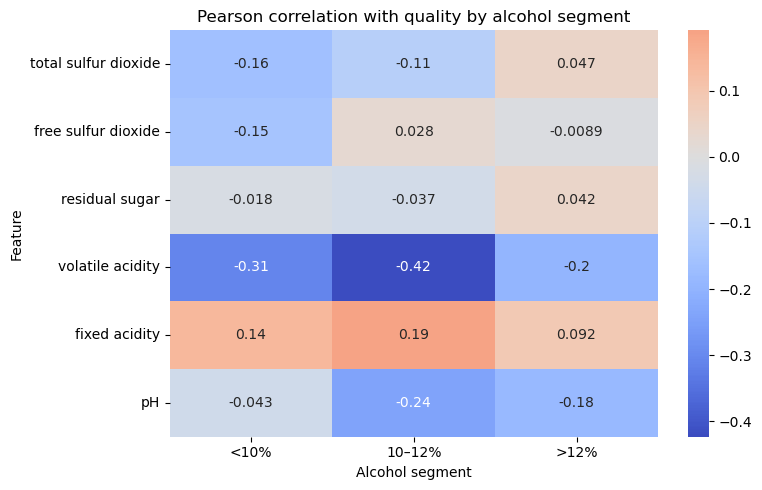

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.heatmap(
    corr_table,
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Pearson correlation with quality by alcohol segment")
plt.xlabel("Alcohol segment")
plt.ylabel("Feature")
plt.tight_layout()
# Save BEFORE show (important)
plt.savefig("pearson_corr_quality_by_alcohol_segment.png", dpi=300, bbox_inches="tight")
plt.show()

In [32]:
for segment in ["<10%", "10–12%", ">12%"]:
    corr = wine_quality[
        wine_quality["alcohol_segment_3"] == segment
    ][["alcohol", "quality"]].corr().iloc[0,1]
    
    print(f"{segment}: corr(alcohol, quality) = {corr:.3f}")


<10%: corr(alcohol, quality) = 0.130
10–12%: corr(alcohol, quality) = 0.259
>12%: corr(alcohol, quality) = -0.047


In [33]:
corr_table.head()

,<10%,10–12%,>12%
total sulfur dioxide,-0.162889,-0.108464,0.047416
free sulfur dioxide,-0.150054,0.027575,-0.008900
residual sugar,-0.017947,-0.036552,0.042393
volatile acidity,-0.307380,-0.423187,-0.197174
fixed acidity,0.140055,0.191145,0.091556


## Correlation analysis (Spearman)


In [35]:
# --- Spearman correlation
# Spearman captures monotonic (not necessarily linear) relationships
# and is more robust to outliers than Pearson

import numpy as np

numeric_cols = wine_quality.select_dtypes(include=np.number).columns

spearman_corr =wine_quality[numeric_cols].corr(method="spearman")

spearman_corr


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.271597,0.653749,0.242521,0.272554,-0.190341,-0.093900,0.629644,-0.707010,0.194222,-0.085751,0.103887
volatile acidity,-0.271597,1.000000,-0.601305,0.012988,0.153031,0.021178,0.101862,0.019111,0.222106,-0.343500,-0.223379,-0.397784
citric acid,0.653749,-0.601305,1.000000,0.210283,0.142182,-0.075070,0.007291,0.354884,-0.544998,0.340666,0.090691,0.222882
residual sugar,0.242521,0.012988,0.210283,1.000000,0.201531,0.051230,0.124370,0.422578,-0.108683,0.030979,0.123493,0.030614
chlorides,0.272554,0.153031,0.142182,0.201531,1.000000,0.002484,0.126247,0.426509,-0.249068,0.001763,-0.309720,-0.193814
free sulfur dioxide,-0.190341,0.021178,-0.075070,0.051230,0.002484,1.000000,0.793745,-0.071330,0.113952,0.028295,-0.064219,-0.059213
total sulfur dioxide,-0.093900,0.101862,0.007291,0.124370,0.126247,0.793745,1.000000,0.109786,-0.001788,-0.010544,-0.243461,-0.194570
density,0.629644,0.019111,0.354884,0.422578,0.426509,-0.071330,0.109786,1.000000,-0.316985,0.154057,-0.471354,-0.176505
pH,-0.707010,0.222106,-0.544998,-0.108683,-0.249068,0.113952,-0.001788,-0.316985,1.000000,-0.063352,0.195499,-0.033205
sulphates,0.194222,-0.343500,0.340666,0.030979,0.001763,0.028295,-0.010544,0.154057,-0.063352,1.000000,0.198741,0.393681


In [36]:
# --- Feature association with quality: Spearman
spearman_corr["quality"].sort_values(ascending=False)


quality                 1.000000
alcohol                 0.495439
sulphates               0.393681
citric acid             0.222882
fixed acidity           0.103887
residual sugar          0.030614
pH                     -0.033205
free sulfur dioxide    -0.059213
density                -0.176505
chlorides              -0.193814
total sulfur dioxide   -0.194570
volatile acidity       -0.397784
Name: quality, dtype: float64

Spearman correlation is computed in addition to Pearson to capture monotonic
relationships that may not be strictly linear. This is especially relevant
for chemical variables where threshold or saturation effects are expected.


Spearman correlation confirms and strengthens the main associations observed with Pearson, while highlighting monotonic effects for alcohol, volatile acidity, and sulphates that may not be strictly linear.

## Alcohol range analysis
Alcohol content is known to be strongly associated with wine quality.
However, extreme alcohol values may correspond to specific wine styles
and represent a small fraction of the dataset. Before applying any
filtering, we explore the distribution of alcohol and its relationship
with quality.


In [37]:
# --- Alcohol distribution
wine_quality["alcohol"].describe()


count    1143.000000
mean       10.442111
std         1.082196
min         8.400000
25%         9.500000
50%        10.200000
75%        11.100000
max        14.900000
Name: alcohol, dtype: float64

<Axes: title={'center': 'Alcohol distribution'}, ylabel='Frequency'>

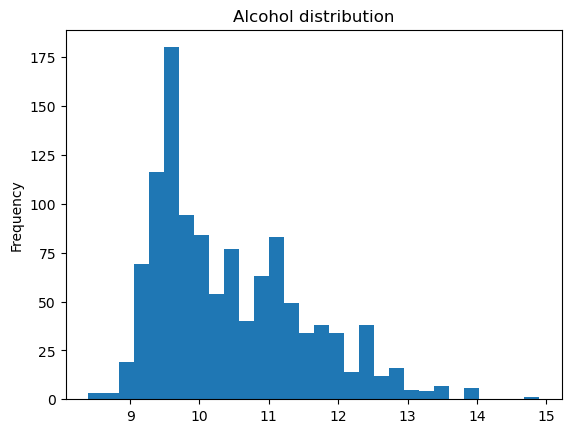

In [39]:
wine_quality["alcohol"].plot(
    kind="hist",
    bins=30,
    title="Alcohol distribution"
)


To better understand how alcohol values are distributed, we group wines
into meaningful alcohol ranges and count observations per group.


In [40]:
# --- Alcohol ranges
alcohol_bins = pd.cut(
    wine_quality["alcohol"],
    bins=[0, 10, 11, 12, 12.5, 13, 20]
)

alcohol_bins.value_counts().sort_index()


alcohol
(0.0, 10.0]     534
(10.0, 11.0]    307
(11.0, 12.0]    199
(12.0, 12.5]     52
(12.5, 13.0]     31
(13.0, 20.0]     20
Name: count, dtype: int64

We compare the number of wines and their average quality across alcohol
ranges to assess whether high-alcohol wines behave differently from
the rest of the dataset.


In [41]:
# --- Quality by alcohol range
wine_quality.groupby(alcohol_bins)["quality"].agg(
    ["count", "mean", "median"]
)


C:\Users\Marta\AppData\Local\Temp\ipykernel_3724\2070060426.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wine_quality.groupby(alcohol_bins)["quality"].agg(


,count,mean,median
alcohol,,,
"(0.0, 10.0]",534,5.314607,5.0
"(10.0, 11.0]",307,5.713355,6.0
"(11.0, 12.0]",199,6.080402,6.0
"(12.0, 12.5]",52,6.557692,7.0
"(12.5, 13.0]",31,6.225806,6.0
"(13.0, 20.0]",20,6.500000,6.5


This analysis allows us to assess whether wines above a certain alcohol
threshold represent a small and potentially distinct subset of the data.
If high-alcohol wines are scarce and show different quality patterns,
filtering by alcohol range may improve model robustness.


The alcohol range analysis shows a clear pattern up to 12.5% alcohol: as alcohol
increases, both mean and median wine quality consistently increase. This confirms
the strong monotonic relationship observed in both Pearson and Spearman correlations.

However, wines above 12.5% alcohol represent a very small fraction of the dataset
(51 wines, approximately 4.5%) and no longer follow this smooth trend. In these
higher alcohol ranges, average quality fluctuates and sample sizes are very small,
suggesting higher variability and potential noise.

These results indicate that high-alcohol wines may correspond to specific styles
and form a distinct, low-density subset of the data. This motivates evaluating
alcohol range filtering in later modeling steps to improve robustness.
